In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('cp_ssl/dips_all_test/results_dict_cutract_1.0_0.0_10_0:v0', type='pickle')
artifact_dir = artifact.download()

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier

from .data_iq import *
from .data_loader import *

dataset_name = 'adult'
prop_data=1
seed=42
nest=100
prop_lab=0.1

2024-04-19 14:44:42.830552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_feat, df_label, df = get_data(dataset=dataset_name, prop=prop_data)

x_train, x_test, y_train, y_test = train_test_split(
    df_feat, df_label, test_size=0.2, random_state=seed
)

# create XGBoost instance with default hyper-parameters
xgb = XGBClassifier()

xgb.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [3]:
# Run Data-IQ
# Note that we use all_x and all_y here
dataiq_xgb = DataIQ_SKLearn_new(X=x_train, y=y_train)

for i in range(1, nest):
    # *** Characterize with Data-IQ [LINE 2] ***
    dataiq_xgb.on_epoch_end(clf=xgb, iteration=i)

In [4]:
confidence = dataiq_xgb.confidence
aleatoric = dataiq_xgb.aleatoric

easy, ambig, hard = get_groups(confidence, aleatoric, 
                               data_iq_xthresh=0.15, 
                               data_iq_ythresh=0.8)

ids = np.argsort(confidence)

x_thresh  0.15
conf_thresh_high  0.19999999999999996
14607 9140 392


<Axes: >

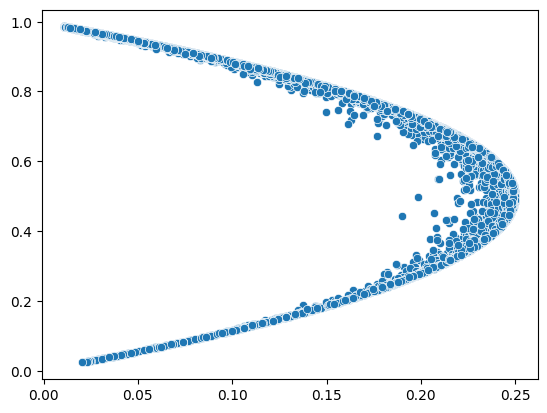

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(y=confidence, x=aleatoric)

In [6]:
train_dyn = dataiq_xgb.gold_labels_probabilities
# # random sample 100 points from the train_dyn
# train_dyn = train_dyn[np.random.choice(train_dyn.shape[0], 10, replace=False), :]

# #train_dyn = train_dyn[ids[0:10], :]

# train_dyn.shape

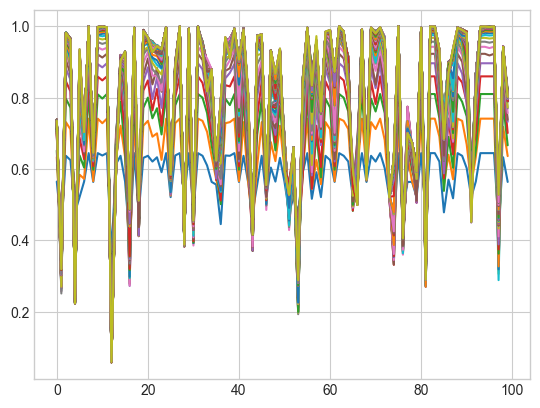

In [18]:
plt.plot(train_dyn[np.random.choice(train_dyn.shape[0], 100, replace=False), :])

In [7]:
easy_dyn = train_dyn[easy, :]

# combine ambig & hard
ambig_hard = np.concatenate((ambig, hard), axis=0)

#extract combined
ambig_hard_dyn = train_dyn[ambig_hard, :]

ambig_dyn = train_dyn[ambig, :]
hard_dyn = train_dyn[hard, :]

# get the mean of the easy, ambig, hard
easy_dyn_mean = np.mean(easy_dyn, axis=0)
ambig_dyn_mean = np.mean(ambig_dyn, axis=0)
hard_dyn_mean = np.mean(hard_dyn, axis=0)

# get mean of easy_ambig
ambig_hard_dyn_mean = np.mean(ambig_hard_dyn, axis=0)

/var/folders/dn/_sc9xwsn55zds45y9hlhjngh0000gn/T/ipykernel_34967/3825843532.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


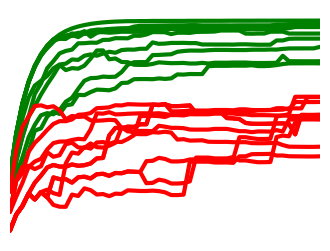

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
import seaborn as sns

#plt.style.use(['science', 'ieee', "no-latex"])
plt.style.use('seaborn-whitegrid')

plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'normal'
#plt.plot(easy_dyn_mean, label='easy', color='b')
# sample and plot 10 samples from easy_dyn with alpha=0.1 without a for loop

# set figure size
plt.figure(figsize=(4, 3))

n=10
width=3

for i in range(n):
    if i==0:
        plt.plot(easy_dyn[np.random.choice(easy_dyn.shape[0], 1, replace=False), :].T, color='g', alpha=1, label='Useful', linestyle='-', linewidth=width)
    else:
        plt.plot(easy_dyn[np.random.choice(easy_dyn.shape[0], 1, replace=False), :].T, color='g', alpha=1, linestyle='-', linewidth=width)

# get the indices of ambig_hard where confidence < 0.6
ambig_hard_conf_idx = np.where(np.max(ambig_hard_dyn,axis=1)> 0.8)[0]

# get the ambig_hard_dyn where confidence < 0.6
ambig_hard_dyn_conf = ambig_hard_dyn[ambig_hard_conf_idx, :]

# plot ambig_hard_dyn_conf
for i in range(n):

    if i==0:
        plt.plot(ambig_hard_dyn_conf[np.random.choice(ambig_hard_dyn_conf.shape[0], 1, replace=False), :].T, color='red', alpha=1, label='Harmful', linestyle='-', linewidth=width)

    else:
        plt.plot(ambig_hard_dyn_conf[np.random.choice(ambig_hard_dyn_conf.shape[0], 1, replace=False), :].T, color='red', alpha=1, linestyle='-', linewidth=width)

# remove grid line x
plt.grid(axis='x', alpha=0.0)

# remove ticks x and y axis
plt.tick_params(axis='both', which='both', bottom=False, top=False, right=False, left=False)

# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.xlabel('Epochs/Iterations')
# plt.ylabel('Probability of true label')

# set font size of legend, ticks and labels
fsize=20
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('xtick', labelsize=fsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fsize)    # fontsize of the tick labels
plt.rc('axes', labelsize=fsize)     # fontsize of the x and y labels

plt.xlim(0,50)
# put legend at the above
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fancybox=True, shadow=True)

# remove all ticks and labels
plt.xticks([])
plt.yticks([])

# remove axis spines
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


#plt.savefig('training_dynamics.p', bbox_inches='tight', dpi=1024)

# plt.savefig('training_dynamics.svg', format = 'svg', dpi=1024)

/var/folders/dn/_sc9xwsn55zds45y9hlhjngh0000gn/T/ipykernel_34967/2284406846.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


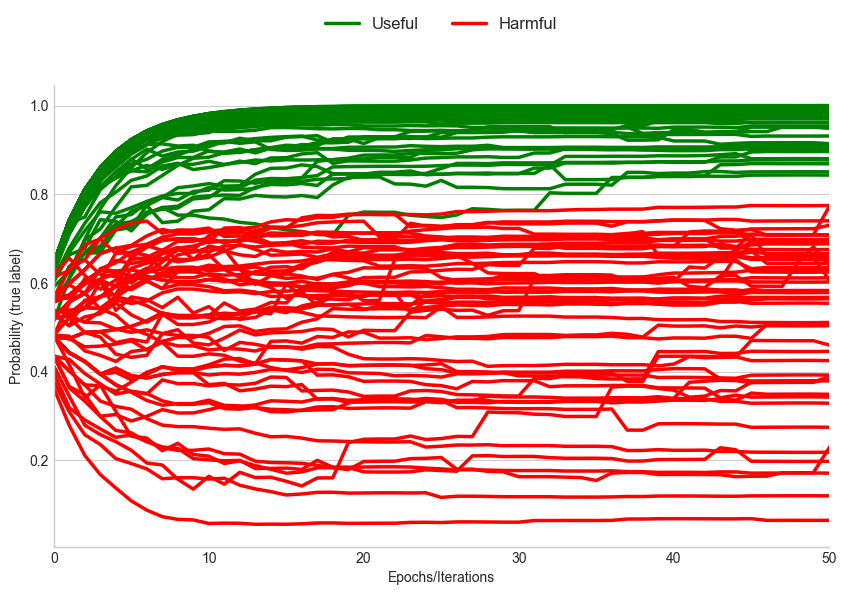

In [179]:
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
import seaborn as sns

#plt.style.use(['science', 'ieee', "no-latex"])
plt.style.use('seaborn-whitegrid')

# plt.rcParams['font.family'] = 'Roboto'
# plt.rcParams['font.size'] = 12
# plt.rcParams['font.weight'] = 'normal'
#plt.plot(easy_dyn_mean, label='easy', color='b')
# sample and plot 10 samples from easy_dyn with alpha=0.1 without a for loop

# set figure size
plt.figure(figsize=(10, 6))

n=50
width=2.5

for i in range(n):
    if i==0:
        plt.plot(easy_dyn[np.random.choice(easy_dyn.shape[0], 1, replace=False), :].T, color='g', alpha=1, label='Useful', linestyle='-', linewidth=width)
    else:
        plt.plot(easy_dyn[np.random.choice(easy_dyn.shape[0], 1, replace=False), :].T, color='g', alpha=1, linestyle='-', linewidth=width)

# get the indices of ambig_hard where confidence < 0.6
ambig_hard_conf_idx = np.where(np.max(ambig_hard_dyn,axis=1)<0.8)[0]

# get the ambig_hard_dyn where confidence < 0.6
ambig_hard_dyn_conf = ambig_hard_dyn[ambig_hard_conf_idx, :]

# plot ambig_hard_dyn_conf
for i in range(n):

    if i==0:
        plt.plot(ambig_hard_dyn_conf[np.random.choice(ambig_hard_dyn_conf.shape[0], 1, replace=False), :].T, color='red', alpha=1, label='Harmful', linestyle='-', linewidth=width)

    else:
        plt.plot(ambig_hard_dyn_conf[np.random.choice(ambig_hard_dyn_conf.shape[0], 1, replace=False), :].T, color='red', alpha=1, linestyle='-', linewidth=width)

# remove grid line x
plt.grid(axis='x', alpha=0.0)

# remove ticks x and y axis
plt.tick_params(axis='both', which='both', bottom=False, top=False, right=False, left=False)

# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Epochs/Iterations')
plt.ylabel('Probability (true label)')

# set font size of legend, ticks and labels
fsize=10
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('xtick', labelsize=fsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fsize)    # fontsize of the tick labels
plt.rc('axes', labelsize=fsize)     # fontsize of the x and y labels

plt.xlim(0,50)
# put legend at the above
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2, fancybox=True, shadow=True)

# # remove all ticks and labels
# plt.xticks([])
# plt.yticks([])

# plt.savefig('training_dynamics.pdf', bbox_inches='tight')

In [153]:
df_results = pd.DataFrame(columns=["accuracy", "method", "time"])

df_results = df_results.append({"accuracy":65, "method": "dips", "time": 2.2533333333333334}, ignore_index=True)
df_results = df_results.append({"accuracy":70, "method": "dips", "time":4.586666666666667}, ignore_index=True)
df_results = df_results.append({"accuracy":75, "method": "dips", "time":10.813333333333333}, ignore_index=True)
df_results = df_results.append({"accuracy":80, "method": "dips", "time":27.840000000000003}, ignore_index=True)
df_results = df_results.append({"accuracy":65, "method": "vanilla", "time":7.973333333333334}, ignore_index=True)
df_results = df_results.append({"accuracy":70, "method": "vanilla", "time":16.373333333333335}, ignore_index=True)
df_results = df_results.append({"accuracy":75, "method": "vanilla", "time":26.53333333333333}, ignore_index=True)
df_results = df_results.append({"accuracy":80, "method": "vanilla", "time":35.78666666666667}, ignore_index=True)

/var/folders/k4/12dwsfj93d17crrg8wnzq5r00000gn/T/ipykernel_1946/3286159915.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({"accuracy":65, "method": "dips", "time": 2.2533333333333334}, ignore_index=True)
/var/folders/k4/12dwsfj93d17crrg8wnzq5r00000gn/T/ipykernel_1946/3286159915.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({"accuracy":70, "method": "dips", "time":4.586666666666667}, ignore_index=True)
/var/folders/k4/12dwsfj93d17crrg8wnzq5r00000gn/T/ipykernel_1946/3286159915.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({"accuracy":75, "method": "dips", "time":10.813333333333333}, ignore_index=True)
/var/folders/k4/

In [154]:
df_results

,accuracy,method,time
0,65,dips,2.253333
1,70,dips,4.586667
2,75,dips,10.813333
3,80,dips,27.840000
4,65,vanilla,7.973333
5,70,vanilla,16.373333
6,75,vanilla,26.533333
7,80,vanilla,35.786667


In [155]:
957*0.04

38.28

In [156]:
970*0.04

38.800000000000004

In [157]:
np.mean([38.2,38.8])

38.5

In [158]:
np.std([38.2,38.8])

0.29999999999999716